In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from tqdm import tqdm

In [163]:
selected_state = "Georgia"
dataset = pd.read_csv("data/final_dataset.csv")
dataset = dataset[dataset["state_" + selected_state] == True]

dropped_columns = [c for c in dataset.columns if c.startswith('state_')]
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)

dataset_reduced.head()

,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,votes_ratio,totalvotes,population,month_x,month_y
30,2015.0,33.7123,-84.1883,22.0,22.0,23.0,0.0,1.0,0.75,0.25,0.0,0.5,4,15.6,0,0.999324,161320.0,10183353,-2.449294e-16,1.000000e+00
55,2016.0,33.6120,-84.4961,4.0,17.0,30.0,0.0,0.6,0.40,0.00,0.2,0.0,5,14.7,0,1.000000,252833.0,10308442,1.000000e+00,6.123234e-17
79,2014.0,33.4631,-81.9509,37.0,37.0,37.0,0.0,1.0,0.00,0.00,0.0,0.0,1,16.8,1,0.547532,166814.0,10071204,-1.000000e+00,-1.836970e-16
85,2017.0,31.7127,-84.2885,26.0,26.0,26.0,0.0,1.0,1.00,0.50,0.0,0.5,2,13.3,0,0.612298,242599.0,10417031,5.000000e-01,-8.660254e-01
107,2015.0,33.4556,-81.9921,23.0,26.0,29.0,0.0,1.0,0.50,0.00,0.5,0.5,2,15.6,1,0.547532,166814.0,10183353,-5.000000e-01,-8.660254e-01


In [164]:
numeric_dataset = dataset_reduced._get_numeric_data()
numeric_dataset.head()

,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,votes_ratio,totalvotes,population,month_x,month_y
30,2015.0,33.7123,-84.1883,22.0,22.0,23.0,0.0,1.0,0.75,0.25,0.0,0.5,4,15.6,0,0.999324,161320.0,10183353,-2.449294e-16,1.000000e+00
55,2016.0,33.6120,-84.4961,4.0,17.0,30.0,0.0,0.6,0.40,0.00,0.2,0.0,5,14.7,0,1.000000,252833.0,10308442,1.000000e+00,6.123234e-17
79,2014.0,33.4631,-81.9509,37.0,37.0,37.0,0.0,1.0,0.00,0.00,0.0,0.0,1,16.8,1,0.547532,166814.0,10071204,-1.000000e+00,-1.836970e-16
85,2017.0,31.7127,-84.2885,26.0,26.0,26.0,0.0,1.0,1.00,0.50,0.0,0.5,2,13.3,0,0.612298,242599.0,10417031,5.000000e-01,-8.660254e-01
107,2015.0,33.4556,-81.9921,23.0,26.0,29.0,0.0,1.0,0.50,0.00,0.5,0.5,2,15.6,1,0.547532,166814.0,10183353,-5.000000e-01,-8.660254e-01


In [165]:
numeric_dataset.values.shape

(8896, 20)

In [166]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(numeric_dataset.values)
scaled_dataset.shape

(8896, 20)

In [167]:
k = 3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(scaled_dataset)
distances, indices = nbrs.kneighbors(scaled_dataset)
kth_distances = distances[:, k]
distances.shape

(8896, 4)

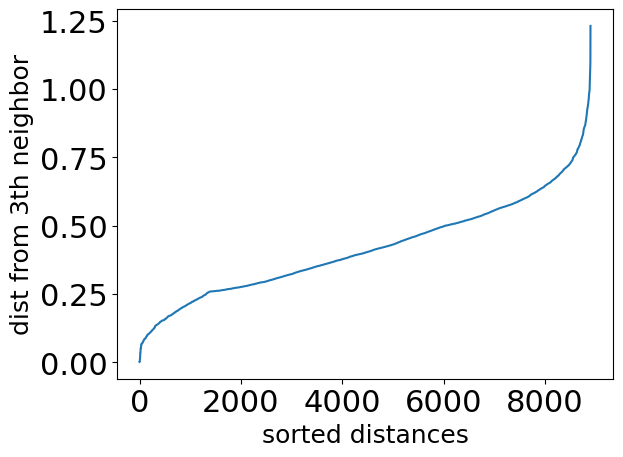

In [168]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [237]:
eps_list = []
n_clusters_list = []
silhouette_score_list = []
davies_bouldin_score_list = []
entropy_list = []
for eps in tqdm(np.arange(0.4, 0.7, 0.001)):
    dbscan = DBSCAN(eps=eps, min_samples=100)
    dbscan.fit(scaled_dataset)
    labels, cluster_num_points = np.unique(dbscan.labels_, return_counts=True)
    n_clusters = len(labels)
    if n_clusters == 1:
        continue
    eps_list.append(eps)
    n_clusters_list.append(n_clusters)
    silhouette_score_list.append(silhouette_score(scaled_dataset, dbscan.labels_))
    davies_bouldin_score_list.append(davies_bouldin_score(scaled_dataset, dbscan.labels_))
    entropy_list.append(entropy(cluster_num_points) / np.log2(n_clusters))

100%|██████████| 300/300 [03:15<00:00,  1.54it/s]


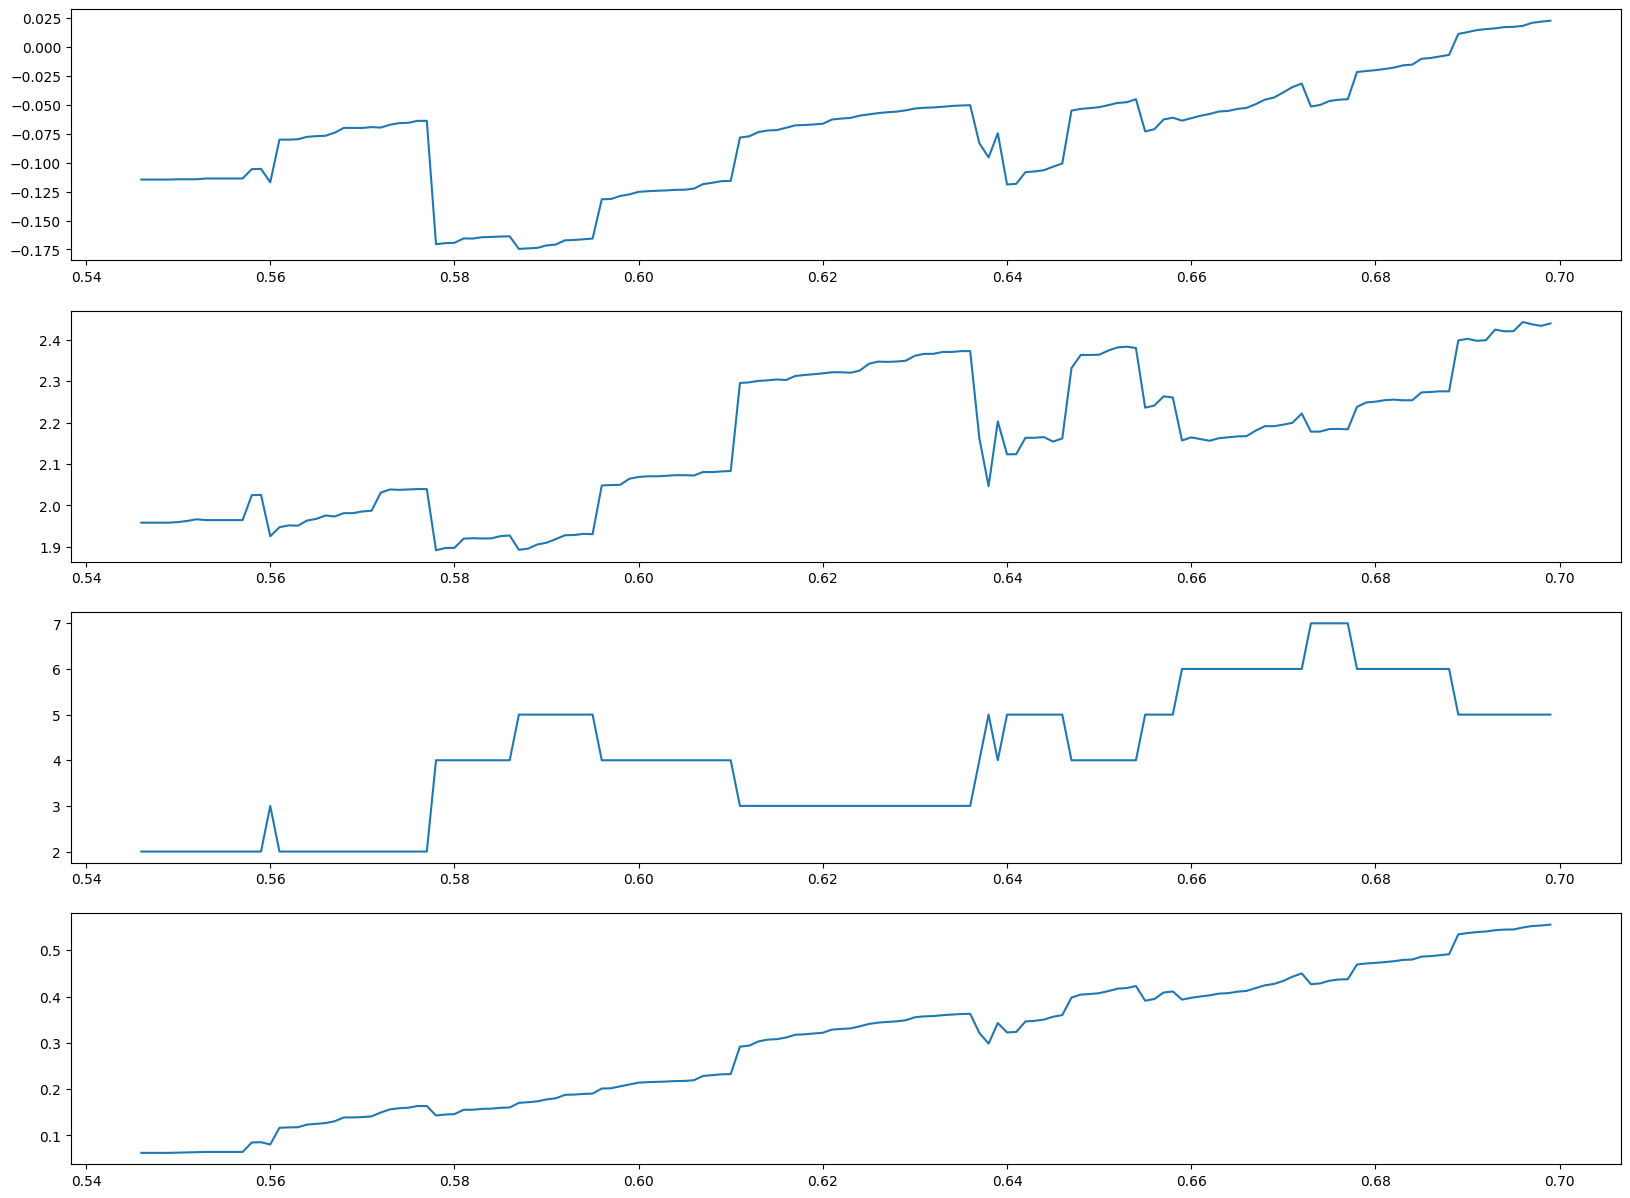

In [238]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))
ax[0].plot(eps_list, silhouette_score_list)
ax[1].plot(eps_list, davies_bouldin_score_list)
ax[2].plot(eps_list, n_clusters_list)
ax[3].plot(eps_list, entropy_list)
plt.show()

In [261]:
dbscan = DBSCAN(eps=0.66, min_samples=100)
dbscan.fit(scaled_dataset)
labels, cluster_num_points = np.unique(dbscan.labels_, return_counts=True)
n_clusters = len(labels)
cluster_num_points

array([5887, 1757,  689,  335,  101,  127])

In [262]:
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[dbscan.labels_ == i-1])

In [263]:
print('Silhouette %s' % silhouette_score(scaled_dataset, dbscan.labels_))
print('Davies-Bouldin %s' % davies_bouldin_score(scaled_dataset, dbscan.labels_))

Silhouette -0.061567988006507084
Davies-Bouldin 2.1641839649969854


[]

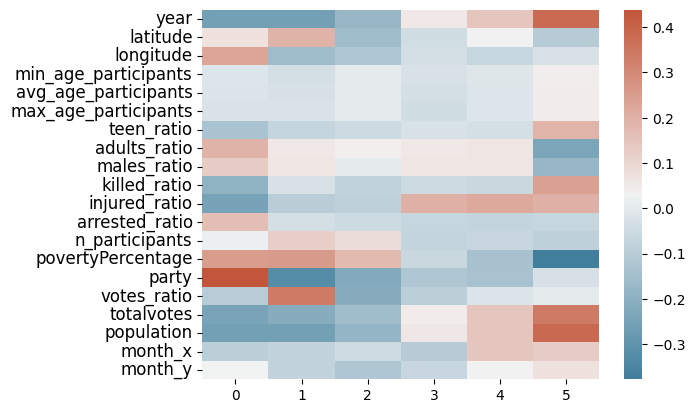

In [264]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(dbscan.labels_), n_clusters))
onehot[np.arange(len(dbscan.labels_)), dbscan.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], fmt = '.2f', cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, numeric_dataset.columns, rotation=0, fontsize=12)
[]

([], [])

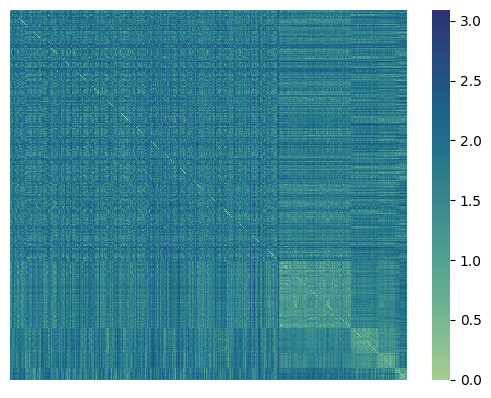

In [265]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = dbscan.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

In [266]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = tsne.fit_transform(scaled_dataset)

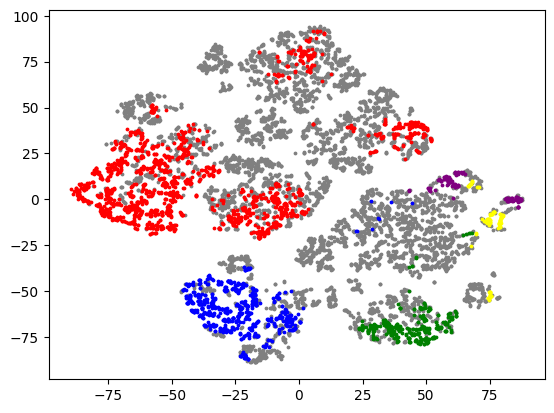

In [267]:
colors = ['gray', 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'brown']
for i in range(n_clusters):
    plt.scatter(tsne_dataset[:,0][dbscan.labels_ == i-1], tsne_dataset[:,1][dbscan.labels_ == i-1], s=3, c=colors[i])
plt.show()

In [268]:
umap_reducer = UMAP().fit(scaled_dataset)


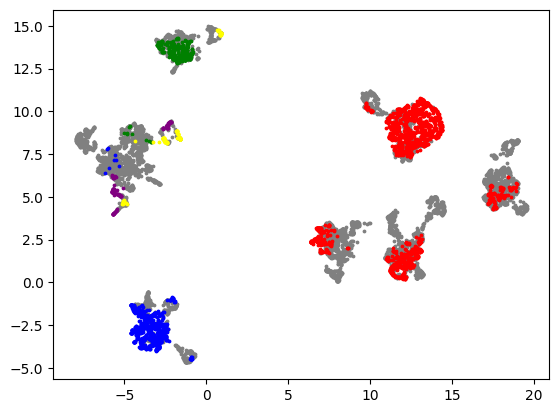

In [ ]:
umap_dataset = umap_reducer.transform(scaled_dataset)
for i in range(n_clusters):
    plt.scatter(umap_dataset[:,0][dbscan.labels_ == i-1], umap_dataset[:,1][dbscan.labels_ == i-1], s=3, c=colors[i])
plt.show()

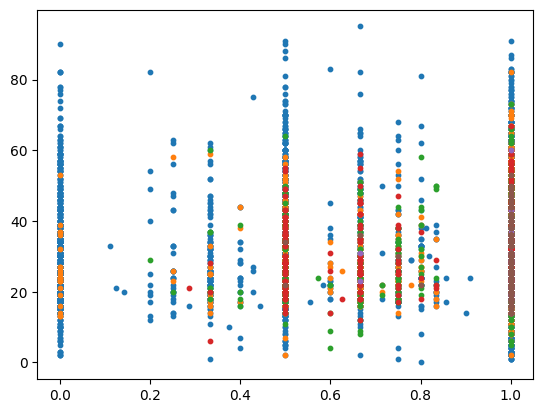

In [ ]:
for i in range(n_clusters):
    plt.scatter(numeric_dataset["males_ratio"][dbscan.labels_ == i-1], numeric_dataset["avg_age_participants"][dbscan.labels_ == i-1], s=10)
plt.show()

In [253]:
party_xt_pct = pd.crosstab(dbscan.labels_, numeric_dataset['party'])
party_xt_pct

party,0,1
row_0,,
-1,2649,3238
0,0,1757
1,689,0
2,335,0
3,101,0
4,127,0


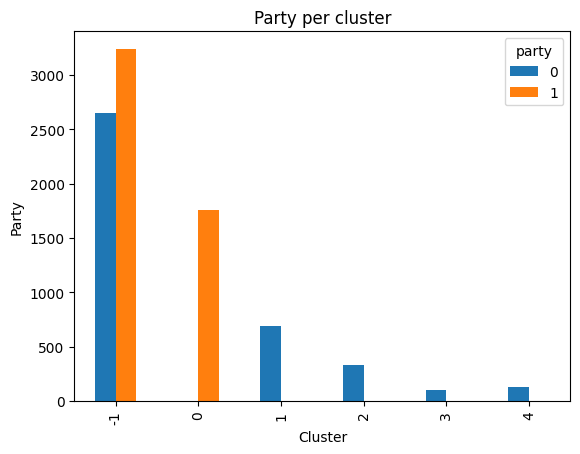

In [254]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')
plt.ylabel('Party')
plt.show()

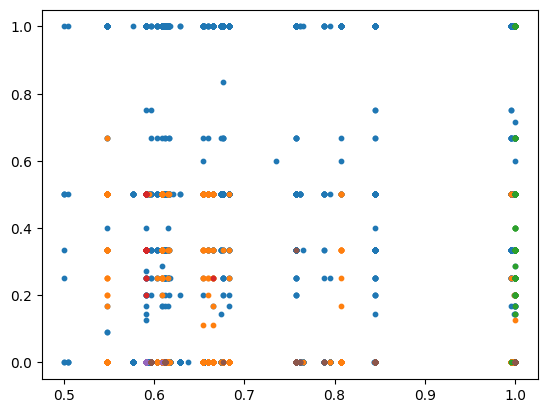

In [255]:
for i in range(n_clusters):
    plt.scatter(numeric_dataset["votes_ratio"][dbscan.labels_ == i-1], numeric_dataset["killed_ratio"][dbscan.labels_ == i-1], s=10)
plt.show()

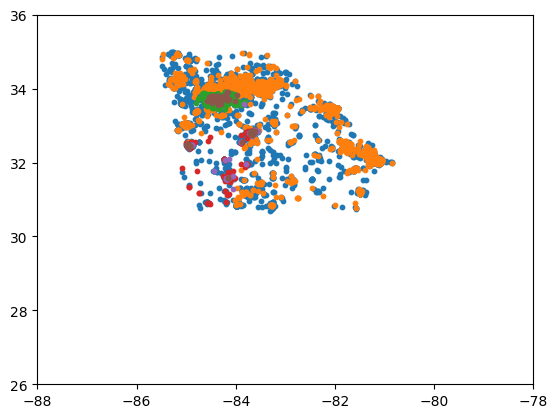

In [256]:
for i in range(n_clusters):
    plt.scatter(numeric_dataset["longitude"][dbscan.labels_ == i-1], numeric_dataset["latitude"][dbscan.labels_ == i-1], s=10)

plt.xlim(-88, -78)
plt.ylim(26, 36)
plt.show()